In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict
import re
import orjson as json
from collections import defaultdict
import numpy as np

## Goodput

In [2]:
mpquiche_goodput =  [
    3142.7296605830697,
    3535.7194889446955,
    3508.195478426399
]

quiche_goodput = [
    2953.3198600411406,
    2741.4635288425548,
    2849.08415409583
]

mcmpquic_goodput = [
    4893.551396353337,
    5041.198594879902,
    5089.272287472016
]

goodput = { "mpquic": mpquiche_goodput, "quic": quiche_goodput, "mcmpquic": mcmpquic_goodput}
print(f"quic: {np.mean(quiche_goodput)} {np.std(quiche_goodput)}")
print(f"mpquic: {np.mean(mpquiche_goodput)} {np.std(mpquiche_goodput)}")
print(f"mcmpquic: {np.mean(mcmpquic_goodput)} {np.std(mcmpquic_goodput)}")

quic: 2847.9558476598418 86.49366479225071
mpquic: 3395.5482093180544 179.12250319655692
mcmpquic: 5008.007426235085 83.27827672760354


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Goodput [Mbps]'),
 Text(0.5, 1.0, 'Goodput comparison between mpquic and quic on a Cloudlab testbed (1GB transfer)')]

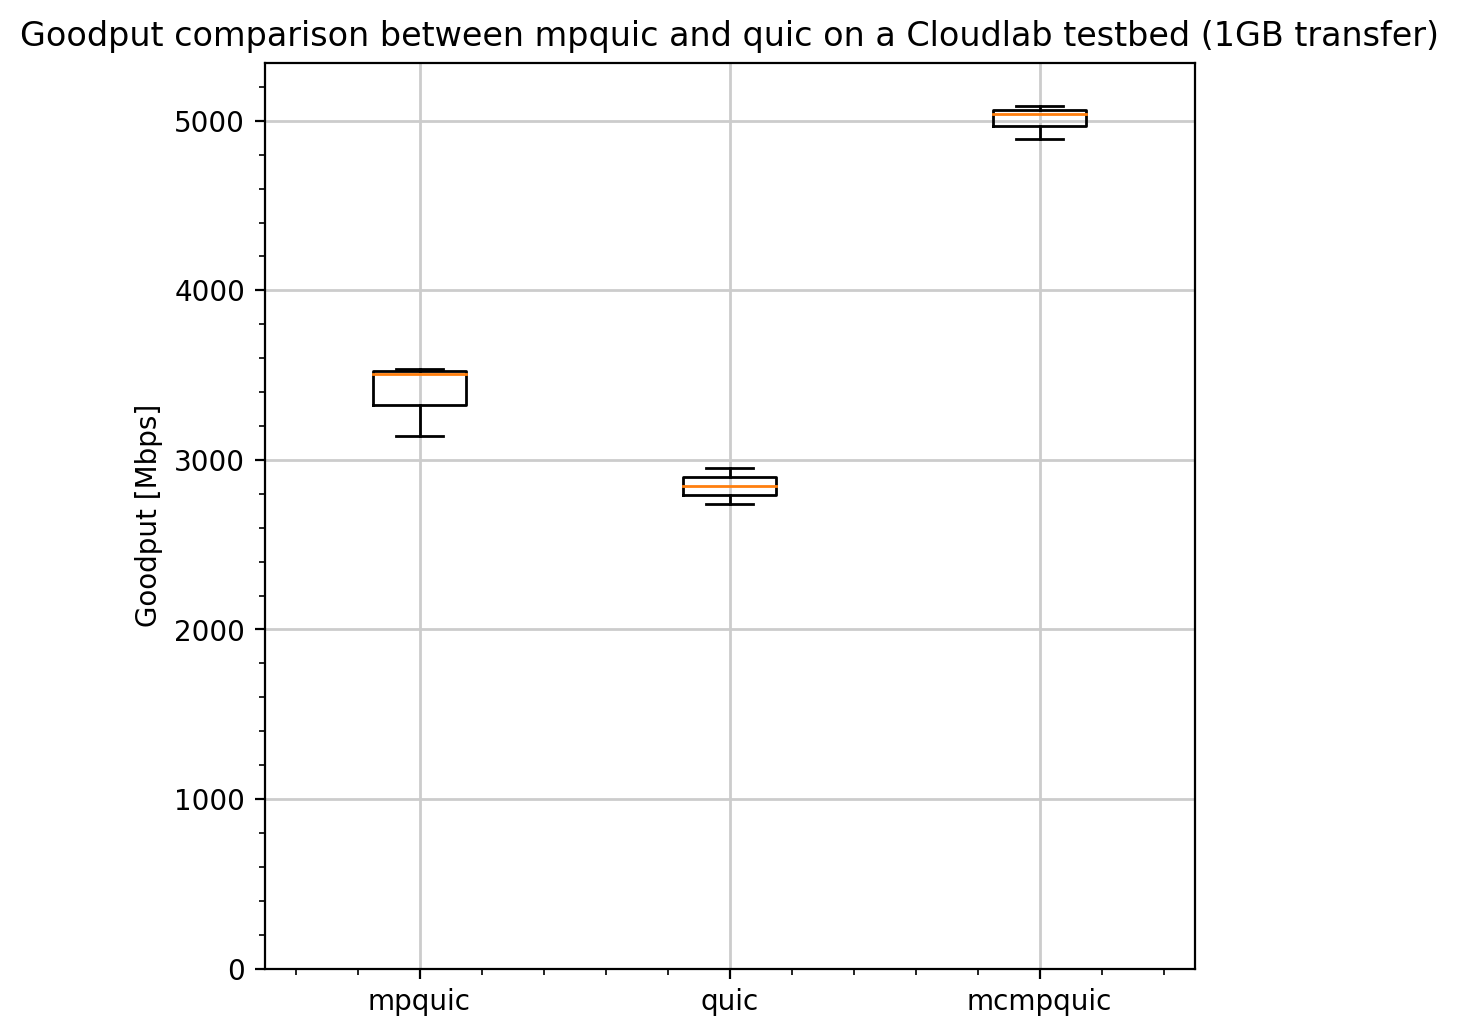

In [3]:
def plot_goodput(ax: plt.Axes, dict: Dict[str, list]):
    max_data = max([max(v) for v in dict.values()])
    ax.boxplot(dict.values(), labels=dict.keys())
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: datetime.utcfromtimestamp(x).strftime("%H:%M:%S")))
    ax.set_ylim(bottom=0, top=max_data * 1.05)
    ax.grid(which='major', color='#CCCCCC', linewidth=1) # Show the major grid
    ax.minorticks_on() # Make the minor ticks and gridlines show
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=200)
plot_goodput(ax, goodput)
ax.set(xlabel="", ylabel="Goodput [Mbps]", title="Goodput comparison between mpquic and quic on a Cloudlab testbed (8GB transfer)")

## Perf

In [4]:
def get_last_symbol(callstack: List[Dict]) -> str:
    for call in reversed(callstack):
        if "symbol" in call:
            return call["symbol"]
    return ""

def parse(perf_json_file, mapping_file, identity) -> dict:
    with open(mapping_file) as f:
        mapping = json.loads(f.read())
    with open(perf_json_file) as f:
        data = json.loads(f.read())
    samples = data["samples"]
    classification = defaultdict(int)
    for sample in samples:
        if "comm" not in sample or sample["comm"] != identity:
            continue
        if "callchain" not in sample:
            continue
        symbol = get_last_symbol(sample["callchain"])
        for mpng, mpng_cat in mapping.items():
            if re.match(mpng[6:], symbol, re.IGNORECASE):
                classification[mpng_cat] += 1
    return classification

In [5]:
def cleaned_perf_up(perf_json_file, mapping_file, identity) -> dict:
    data = parse(perf_json_file, mapping_file, identity)
    new_data = defaultdict(int) 
    total = 0
    for key, value in data.items():
        retained = key.split(" ")[0]
        new_data[retained] += value
        total += value

    for key, value in new_data.items():
        new_data[key] = value / total * 100
    return new_data

In [6]:

quiche_client = cleaned_perf_up("correctness_test_logs/quiche_client_record.json", "quic-10g-mapping.json", "quiche-client")
mpquiche_client = cleaned_perf_up("correctness_test_logs/mpquiche_client_record.json", "quic-10g-mapping.json", "quiche-client")

FileNotFoundError: [Errno 2] No such file or directory: 'correctness_test_logs/quiche_client_record.json'

In [ ]:
def plot_distribution(ax: plt.Axes, dict: Dict[str, list], identity: str):
    labels, data = [], []
    for key, value in dict.items():
        labels.append(key)
        data.append(value)
    ax.bar(labels, data)
    ax.set_xticklabels(labels, rotation=90)
    ax.set(xlabel="", ylabel="CPU cycles (%)", title="Percentage of CPU cycles distribution : " + identity)

/tmp/ipykernel_108221/3148651514.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dict.keys(), rotation=90)


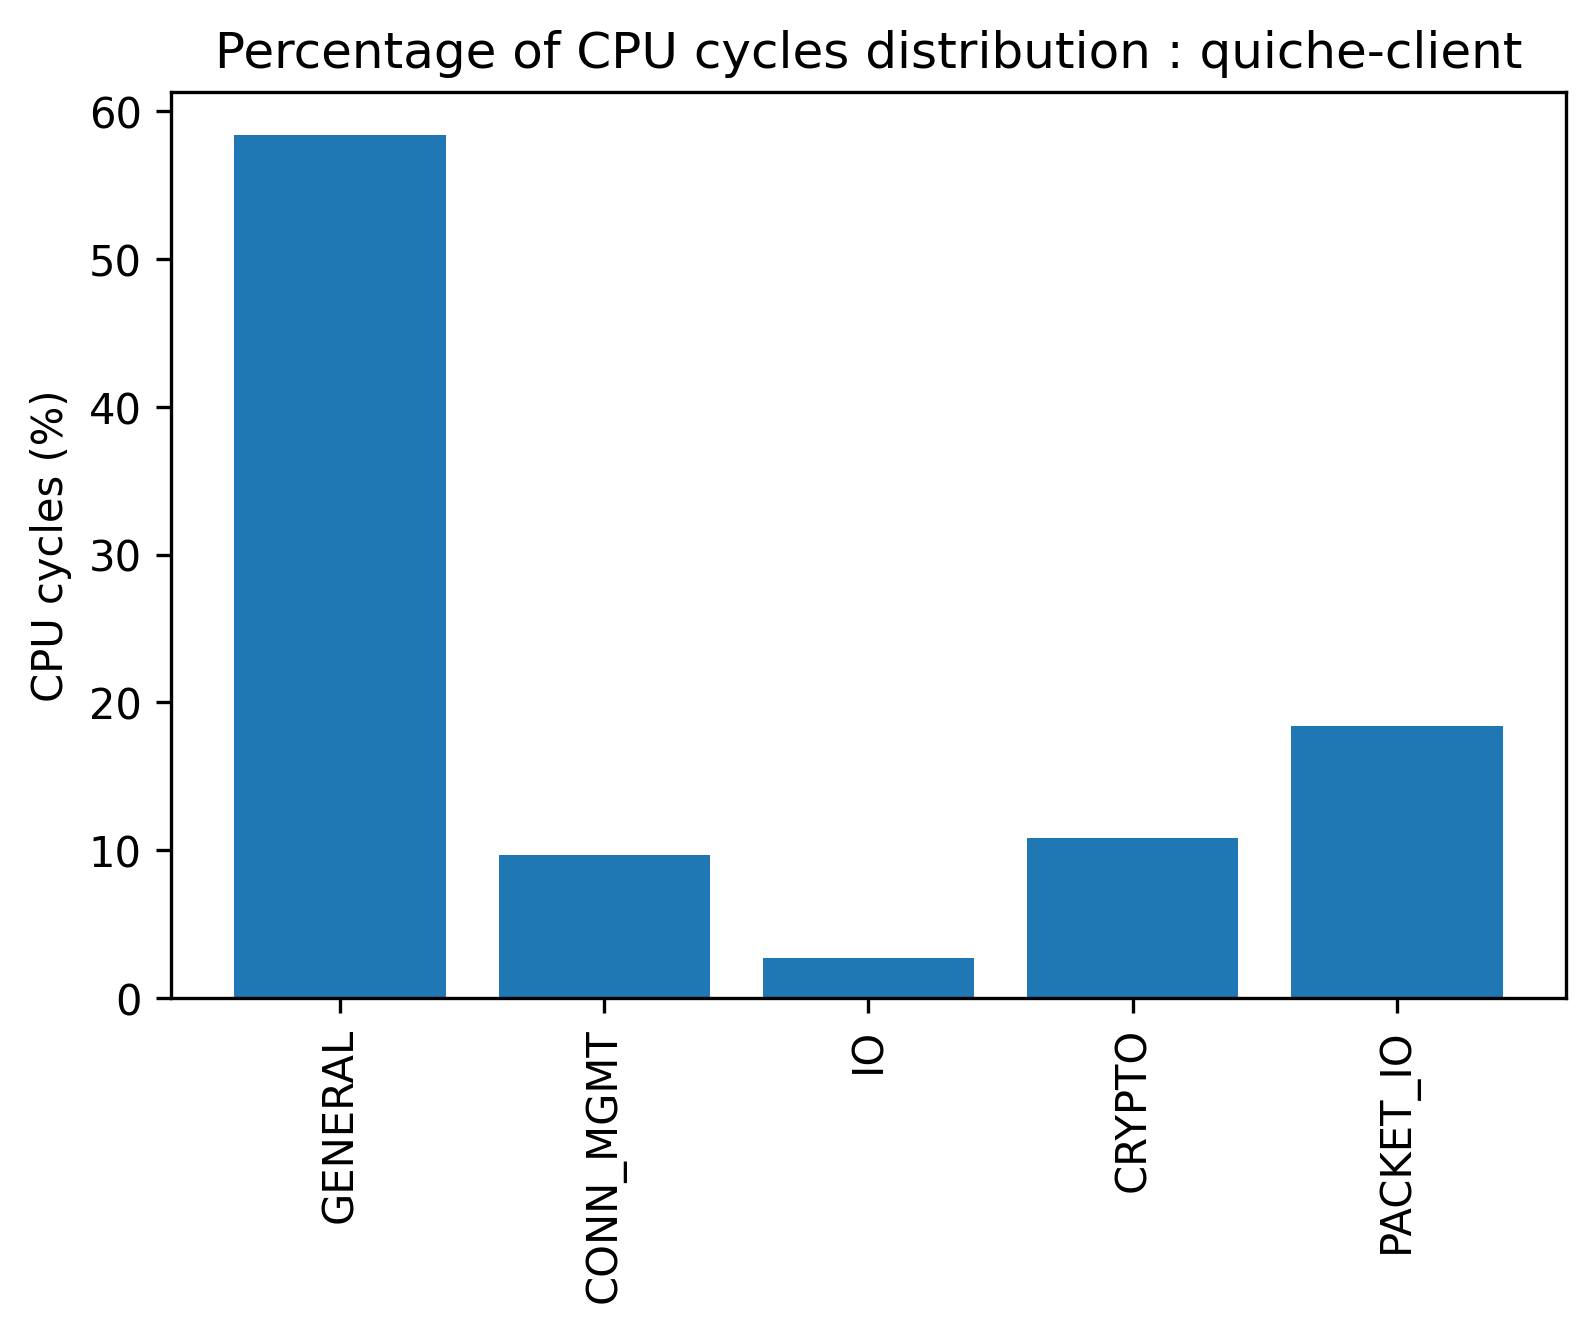

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4), dpi=300)
plot_distribution(ax, quiche_client, identity="quiche-client")

/tmp/ipykernel_108221/3148651514.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dict.keys(), rotation=90)


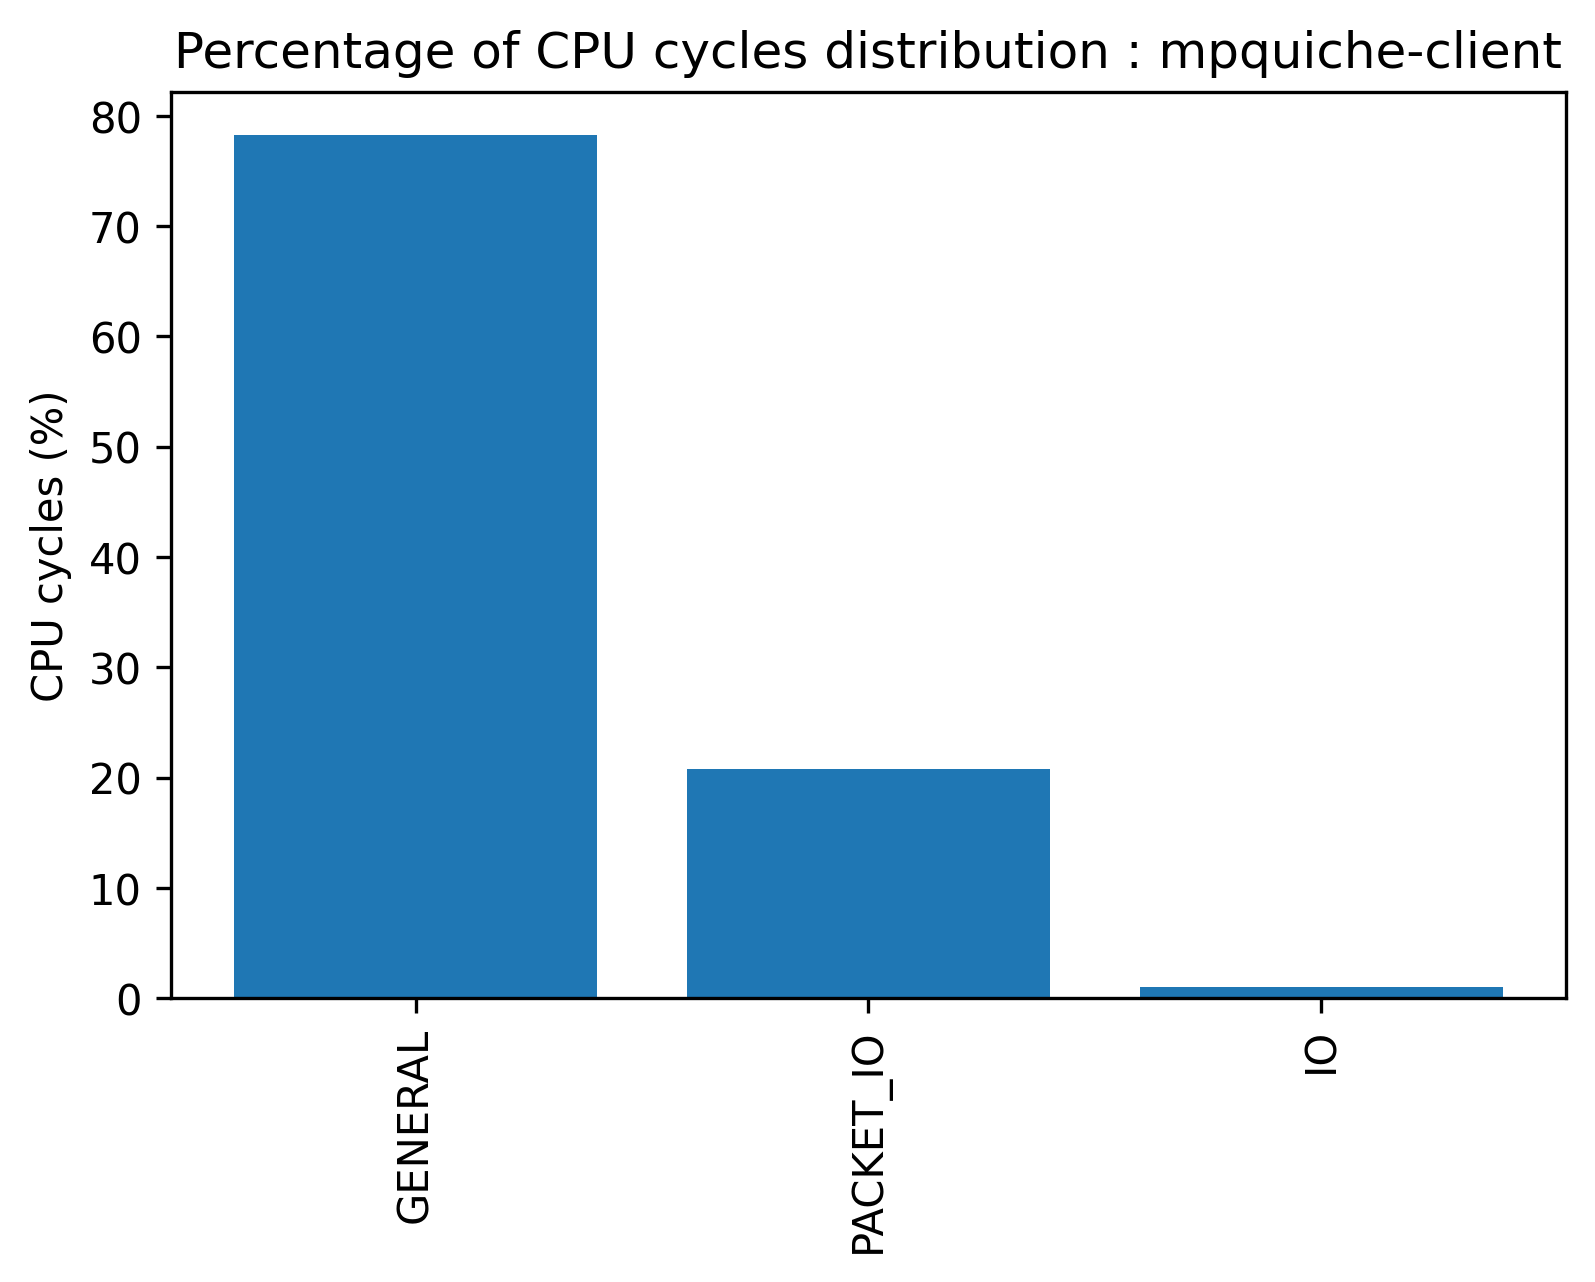

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4), dpi=300)
plot_distribution(ax, mpquiche_client, identity="mpquiche-client")


# Total Transfer Time

In [ ]:
quic_transfer_time =  [
    9.765, 
    9.71, 
    9.78, 
    11.25, 
    12.929, 
    10.276, 
    8.44, 
    12.34, 
    8.34, 
    9.03
]

mpquic_transfer_time = [
    13.33, 
    13.23, 
    14.25, 
    13.9, 
    13.379, 
    13.66, 
    11.642, 
    11.789, 
    12.392, 
    12.92
]

multithread_mpquic_transfer_time = [
    10.714, 
    10.677, 
    11.794, 
    10.71, 
    11.09, 
    11.67, 
    10.583, 
    11.557, 
    11.12, 10.98
]

	#"filesize": 8192,
    #"repetitions": 10,
    #"continue_on_error": true,
    #"use_client_timestamps": true,
    #"only_same_implementation": false,
    #"client_implementaion_params": [
    #    {
    #        "rmem_value": 6815744
    #    }
    #],
    #"server_implementaion_params": [
    #    {
    #        "rmem_value": 6815744
    #    }
    #]

goodput = { "mpquic": mpquic_transfer_time, "quic": quic_transfer_time, "multithreaded mpquic": multithread_mpquic_transfer_time}

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Total Transfer Time [S]'),
 Text(0.5, 1.0, 'Transfer time for a 400MB file. 10 runs each run on an Intel i5 vPro 7th Gen')]

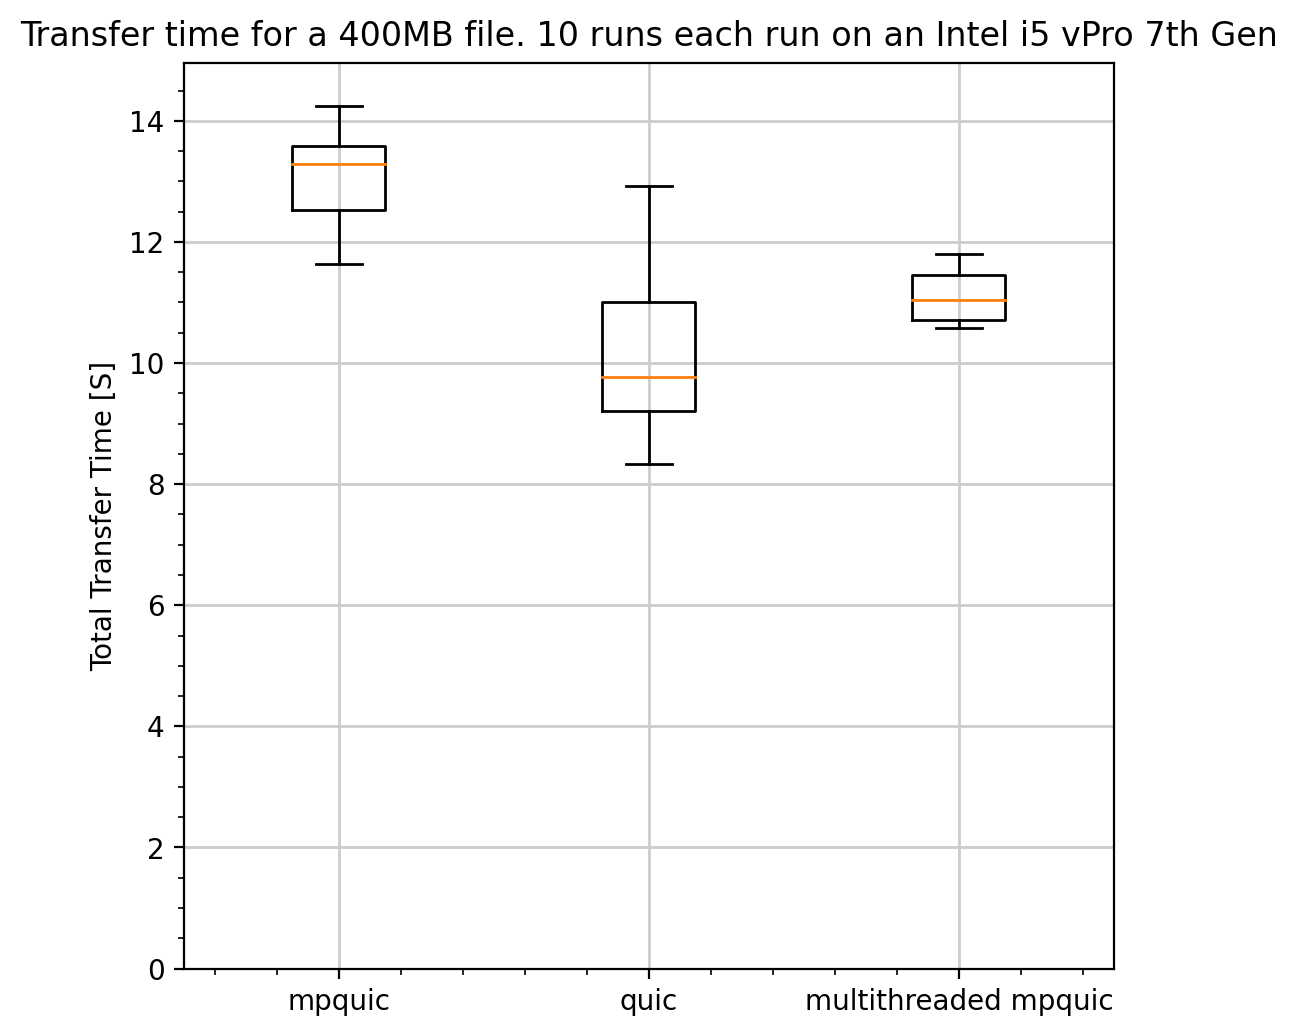

In [ ]:
def plot_goodput(ax: plt.Axes, dict: Dict[str, list]):
    max_data = max([max(v) for v in dict.values()])
    ax.boxplot(dict.values(), labels=dict.keys())
    ax.set_xticks(range(1, len(dict.keys())+1))  # Set xticks to match the labels
    ax.set_ylim(bottom=0, top=max_data * 1.05)
    ax.grid(which='major', color='#CCCCCC', linewidth=1)  # Show the major grid
    ax.minorticks_on()  # Make the minor ticks and gridlines show

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=200)
plot_goodput(ax, goodput)
ax.set(xlabel="", ylabel="Total Transfer Time [S]", title="Transfer time for a 400MB file. 10 runs each run on an Intel i5 vPro 7th Gen")